# Logo Detection

In this notebook we develop a model which is able to locate and lable company logos within static images.

## Import dependencies

In [1]:
import os
import json
import random
import glob

import cv2
import pandas as pd
import matplotlib.pylab as plt
from IPython.display import Image

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [2]:
from summitutils import training

## Load in the training data

The training data is logos on top of office stock images.

In [3]:
logo_train = training.get_dicts(
        'logo_detector_realbkg_large_expanded/combined/train')

logo_train_metadata = training.get_metadata(
        'logo_detector_realbkg_large_expanded/combined_train')

training_info = pd.read_csv(
        'logo_detector_realbkg_large_expanded/combined/train/labels.csv')

labels = list(training_info['class'].unique())

In [4]:
print("There are %d images in the training set." % training_info.shape[0])

There are 5120 images in the training set.


['sas', 'rh', 'anaconda', 'cloudera']


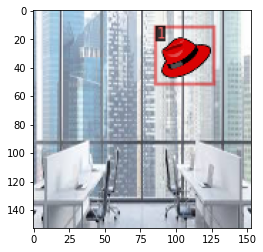

In [5]:
random.seed("summit20")
training.sample_plot(logo_train, logo_train_metadata, './', label_scale=0.3)
print(labels)

## Training the model

In [6]:
training.register('logo_detector_realbkg_large_expanded/combined/',
                  labels, ['train', 'test'])

N_classes = 4
trainer, cfg = training.prepare_for_training(2, 
                                    'logo_detector_realbkg_large_expanded',
                                    'logo_detector_realbkg_large_expanded/combined/_train',
                                    N_classes,
                                    start_training=True)

[04/06 15:42:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[04/06 15:42:38 d2.data.build]: Removed 0 images with no usable annotations. 5120 images left.
[04/06 15:42:38 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    sas     | 1280         |     rh     | 1280         |  anaconda  | 1280         |
|  cloudera  | 1280         |            |              |            |              |
|   total    | 5120         |            |              |            |              |
[04/06 15:42:38 d2.data.common]: Serializing 5120 elements to byte tensors and concatenating them all ...
[04/06 15:42:38 d2.data.common]: Serialized dataset takes 1.24 MiB
[04/06 15:42:38 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/06 15:42:38 d2.data

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (5, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (16, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.


[04/06 15:42:39 d2.engine.train_loop]: Starting training from iteration 0
[04/06 15:43:47 d2.utils.events]:  eta: N/A  iter: 1  total_loss: 2.401  loss_cls: 1.612  loss_box_reg: 0.631  loss_rpn_cls: 0.116  loss_rpn_loc: 0.043    data_time: 0.9342  lr: 0.000000  
[04/06 15:43:47 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


## Validating the model

Next, we see how well our model we just trained performs on labeled data from our test set. 

In [7]:
predictor = training.prepare_for_inference(
    cfg, 'logo_detector_realbkg_large_expanded/combined/test/', threshold=0.34)

logo_test_metadata = training.get_metadata(
    'logo_detector_realbkg_large_expanded/combined/test')

Reading weights from output dir: logo_detector_realbkg_large_expanded


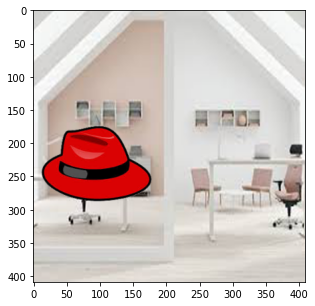

In [8]:
plt.figure(figsize=(5,5))
_ = training.infer_img(predictor,
                       'logo_detector_realbkg_large_expanded/combined/test/rh_aanahw.png',
                       logo_test_metadata)

<img src="./pred4.png" width =300/>


<img src="./pred6.png" width =300/>


In [9]:
f = open("logo_detector_output/metrics_logo.txt", "r")
contents = f.read()
print(contents[3100:])

   | category   | AP     | category   | AP     |
|:-----------|:-------|:-----------|:-------|:-----------|:-------|
| sas        | 95.773 | rh         | 99.854 | anaconda   | 99.867 |
| cloudera   | 99.117 |            |        |            |        |



## Validation on new data

In [10]:
for img in glob.glob('rhlogo_summit_val/*'):
    plt.figure(figsize=(20, 20))
    outputs = training.infer_img_v2(predictor, img, logo_train_metadata)

<img src="./Summit-2.png" width =600/>


<img src="./Summit-3.png" width = 600/>

## Publish the model

This is a two stage process:
1. save model binary to ceph bucket
2. submit a PR showing the model performance data

In [11]:
out = json.dumps({'accuracy': 0.95773})
METRIC_FILE = '../outputs/metrics'
with open(METRIC_FILE, 'w') as f:
    f.write(out)
!git add * && git commit -m "Metrics PR"
!git push

^C
Everything up-to-date
